In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex/data/vireo/pseudo/numC1000_ispropFalse'

In [2]:
AD_F = "cellSNP.tag.AD.mtx"
DP_F = "cellSNP.tag.DP.mtx"
VCF_F = "cellSNP.base.vcf"
INDIR='.'
OUTDIR='./results/'
NUM_DONORS=2
prob_threshold=0.8
indirs = ("data/PBMC_J_cellSNP", "data/PBMC_P_cellSNP")

In [3]:
import os
import pandas as pd
import seaborn as sns
from glob import glob
from scipy import stats
from os.path import join
import numpy as np

In [4]:
if not os.path.exists(OUTDIR):
    os.mkdir(OUTDIR)

In [5]:

in_cell_f = glob(join(INDIR,"cell_indices_*.txt"))
in_cell_names = []
cell_map = {}
for curr_cell_f in in_cell_f:
    print(curr_cell_f)
    with open(curr_cell_f, "r") as f:
        count = 0
        lines = []
        for line in f: 
            if count == 0:
                curr_f = line.strip()
            else:
                lines.append(line.strip().split(','))
            count += 1
    curr_df = pd.DataFrame(lines[1:], columns=lines[0])
    cell_map[curr_f] = curr_df["new index"].astype(int).values
    in_cell_names.append(curr_f)

./cell_indices_0.txt
./cell_indices_1.txt


# Examples of using vireoSNP for donor deconvolution

In [7]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread

## Load cellSNP data 

##### Option 1 - VCF format

In [10]:
# cell_vcf = vireoSNP.load_VCF(VCF_F, biallelic_only=True)
# cell_dat = vireoSNP.vcf.read_sparse_GeneINFO(cell_vcf['GenoINFO'], keys=['AD', 'DP'])

# AD = cell_dat['AD']
# DP = cell_dat['DP']

##### Option 2 - sparse matrices

In [10]:
AD = mmread(AD_F).tocsc()
AD_dense = pd.DataFrame(AD.todense())
DP = mmread(DP_F).tocsc()
DP_dense = pd.DataFrame(DP.todense())
vcf = pd.read_csv(VCF_F, sep='\t')

In [9]:
vcf.head()

,#CHROM,POS,ID_x,REF_x,ALT,QUAL_x,FILTER_x,INFO_x,ID_y,REF_y,QUAL_y,FILTER_y,INFO_y,new ID
0,chr1,2290818,.,G,C,.,PASS,AD=34;DP=34;OTH=2,NaN,NaN,NaN,NaN,NaN,1
1,chr1,3624769,.,C,T,.,PASS,AD=0;DP=23;OTH=1,NaN,NaN,NaN,NaN,NaN,2
2,chr1,16237293,.,G,T,.,PASS,AD=1;DP=1;OTH=19,NaN,NaN,NaN,NaN,NaN,3
3,chr1,16904143,.,A,C,.,PASS,AD=1;DP=1;OTH=29,NaN,NaN,NaN,NaN,NaN,4
4,chr1,21294734,.,G,A,.,PASS,AD=0;DP=90;OTH=1,NaN,NaN,NaN,NaN,NaN,5


## Calculate AF. Then correlate with density

In [12]:
vcf

,#CHROM,POS,ID_x,REF_x,ALT,QUAL_x,FILTER_x,INFO_x,ID_y,REF_y,QUAL_y,FILTER_y,INFO_y,new ID
0,chr1,2290818,.,G,C,.,PASS,AD=34;DP=34;OTH=2,NaN,NaN,NaN,NaN,NaN,1
1,chr1,3624769,.,C,T,.,PASS,AD=0;DP=23;OTH=1,NaN,NaN,NaN,NaN,NaN,2
2,chr1,16237293,.,G,T,.,PASS,AD=1;DP=1;OTH=19,NaN,NaN,NaN,NaN,NaN,3
3,chr1,16904143,.,A,C,.,PASS,AD=1;DP=1;OTH=29,NaN,NaN,NaN,NaN,NaN,4
4,chr1,21294734,.,G,A,.,PASS,AD=0;DP=90;OTH=1,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,chrX,129906125,NaN,NaN,C,NaN,NaN,NaN,.,T,.,PASS,AD=0;DP=1;OTH=60,1874
1874,chrX,135098900,NaN,NaN,A,NaN,NaN,NaN,.,G,.,PASS,AD=0;DP=83;OTH=1,1875
1875,chrX,149938651,NaN,NaN,G,NaN,NaN,NaN,.,C,.,PASS,AD=0;DP=70;OTH=1,1876
1876,chrX,150898821,NaN,NaN,A,NaN,NaN,NaN,.,G,.,PASS,AD=0;DP=4;OTH=41,1877


In [15]:
vcf[["#CHROM","POS","ALT", "new ID"]]

,#CHROM,POS,ALT,new ID
0,chr1,2290818,C,1
1,chr1,3624769,T,2
2,chr1,16237293,T,3
3,chr1,16904143,C,4
4,chr1,21294734,A,5
...,...,...,...,...
1873,chrX,129906125,C,1874
1874,chrX,135098900,A,1875
1875,chrX,149938651,G,1876
1876,chrX,150898821,A,1877


In [18]:
AD_dense.index = vcf.set_index(["#CHROM","POS","ALT", "new ID"]).index

AD_dense

In [20]:
DP_dense.index = vcf.set_index(["#CHROM","POS","ALT", "new ID"]).index

DP_dense

0     1     2     3     4     5     6     7     \
#CHROM POS       ALT new ID                                                   
chr1   2290818   C   1          0     0     0     0     0     0     0     0   
       3624769   T   2          0     0     0     0     0     0     0     0   
       16237293  T   3          0     0     0     0     0     0     0     0   
       16904143  C   4          0     0     0     0     0     0     0     0   
       21294734  A   5          0     0     0     0     0     0     0     0   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
chrX   129906125 C   1874       0     0     0     0     0     0     0     0   
       135098900 A   1875       0     0     0     0     0     0     0     0   
       149938651 G   1876       0     0     0     0     0     0     0     0   
       150898821 A   1877       0     0     0     0     0     0     0     0   
       154378630 G   1878       0     0     0     0     0     0     0     0   

                             8     9     ...  1411  1412  1413  1414  1415  \
#CHROM POS       ALT new ID              ...                                 
chr1   2290818   C   1          0     0  ...     0     0     0     0     0   
       3624769   T   2          0     0  ...     0     0     0     0     0   
       16237293  T   3          0     0  ...     0     0     0     0     0   
       16904143  C   4          0     0  ...     0     0     0     0     0   
       21294734  A   5          0     0  ...     0     0     0     0     0   
...                           ...   ...  ...   ...   ...   ...   ...   ...   
chrX   129906125 C   1874       0     0  ...     0     0     0     0     0   
       135098900 A   1875       0     0  ...     0     0     0     0     0   
       149938651 G   1876       0     0  ...     0     0     0     0     2   
       150898821 A   1877       0     0  ...     0     0     0     0     0   
       154378630 G   1878       0     0  ...     0     0     0     0     0   

                             1416  1417  1418  1419  1420  
#CHROM POS       ALT new ID                                
chr1   2290818   C   1          0     0     0     0     0  
       3624769   T   2          0     0     0     0     0  
       16237293  T   3          0     0     0     0     0  
       16904143  C   4          0     0     0     0     0  
       21294734  A   5          0     0     0     0     0  
...                           ...   ...   ...   ...   ...  
chrX   129906125 C   1874       0     0     0     0     0  
       135098900 A   1875       0     0     0     0     0  
       149938651 G   1876       0     0     0     0     0  
       150898821 A   1877       0     0     0     0     0  
       154378630 G   1878       0     0     0     0     0  

[1878 rows x 1421 columns]

In [26]:
pseudo=0.001
AF = AD_dense/(DP_dense+pseudo)
AF

0     1     2     3     4     5     6     7     \
#CHROM POS       ALT new ID                                                   
chr1   2290818   C   1        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
       3624769   T   2        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
       16237293  T   3        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
       16904143  C   4        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
       21294734  A   5        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
chrX   129906125 C   1874     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
       135098900 A   1875     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
       149938651 G   1876     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
       150898821 A   1877     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
       154378630 G   1878     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                             8     9     ...  1411  1412  1413  1414  1415  \
#CHROM POS       ALT new ID              ...                                 
chr1   2290818   C   1        0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
       3624769   T   2        0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
       16237293  T   3        0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
       16904143  C   4        0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
       21294734  A   5        0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
...                           ...   ...  ...   ...   ...   ...   ...   ...   
chrX   129906125 C   1874     0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
       135098900 A   1875     0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
       149938651 G   1876     0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
       150898821 A   1877     0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   
       154378630 G   1878     0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   

                             1416  1417  1418  1419  1420  
#CHROM POS       ALT new ID                                
chr1   2290818   C   1        0.0   0.0   0.0   0.0   0.0  
       3624769   T   2        0.0   0.0   0.0   0.0   0.0  
       16237293  T   3        0.0   0.0   0.0   0.0   0.0  
       16904143  C   4        0.0   0.0   0.0   0.0   0.0  
       21294734  A   5        0.0   0.0   0.0   0.0   0.0  
...                           ...   ...   ...   ...   ...  
chrX   129906125 C   1874     0.0   0.0   0.0   0.0   0.0  
       135098900 A   1875     0.0   0.0   0.0   0.0   0.0  
       149938651 G   1876     0.0   0.0   0.0   0.0   0.0  
       150898821 A   1877     0.0   0.0   0.0   0.0   0.0  
       154378630 G   1878     0.0   0.0   0.0   0.0   0.0  

[1878 rows x 1421 columns]

In [31]:
AF.isnull().any().any()

False

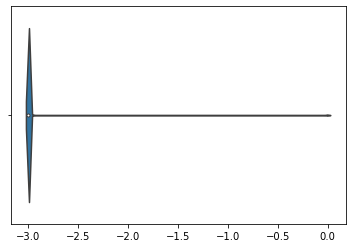

In [35]:
sns.violinplot(np.log10(0.001+AF.values.flatten()))

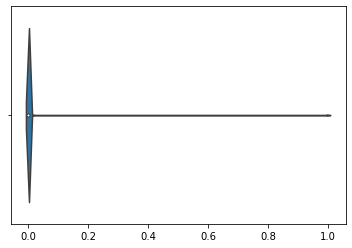

In [38]:
sns.violinplot(AF.values.flatten())

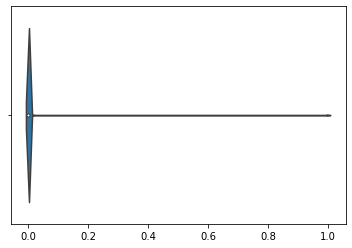

In [38]:
sns.violinplot(AF.values.flatten())

In [40]:
len(AF.values.flatten()[AF.values.flatten()>0])

16322

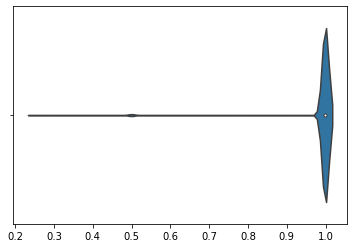

In [43]:
sns.violinplot((AF.values.flatten()[AF.values.flatten()>0]))

In [44]:
max_v = 0
for i in in_cell_names:
    max_v = max(max_v, max(cell_map[i]))
    
# create index map:
cell_ind_map = {}
count = 0
for i in in_cell_names: 
    cell_ind_map[i] = count
    count += 1

cell_inds = -1*np.ones(max_v)
for i in in_cell_names:
    cell_inds[cell_map[i]-1] = cell_ind_map[i] #cell_map[i]
cell_inds

array([0., 0., 0., ..., 1., 1., 1.])

In [45]:
(cell_inds==0).sum()

758

In [ ]:
cell_inds[]